In [1]:
import pandas as pd
import os 
import math, codecs, random, zipfile
from collections import Counter
import numpy as np
import torch
import torch.nn as nn
import gc
from sklearn.metrics import roc_auc_score

USE_GPU=True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    USE_GPU = False

C:\Users\Ben\Anaconda3\envs\Cs589\lib\site-packages\sklearn\utils\fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


In [2]:
root_dir = os.path.abspath('.')
data_dir = os.path.join(root_dir, 'dataset')
train = pd.read_csv(os.path.join(data_dir,'train.csv'))
test = pd.read_csv(os.path.join(data_dir,'test.csv'))

In [3]:
# Taken and adapted From Homework 2 utils.py
def load_embeddings(fname, vocab, idx_to_w):
    vec_file = zipfile.ZipFile('glove.6B.50d.txt.zip', 'r').open('glove.6B.50d.txt', 'r')

    glove_W = {}
    for line in vec_file:
        split = line.strip().split()
        split[0] = split[0].lower().decode('utf-8') # all tokens are lowercased in our dataset
        try:            
            glove_W[split[0]] = np.array(split[1:], dtype="float32")
        except:
            pass

    W = np.random.randn(len(vocab), len(glove_W['the']))
    missing = []
    for i in range(len(vocab)):
        w = idx_to_w[i]
        if w in glove_W:
            W[i] = glove_W[w]
        else:
            missing.append(w)
            W[i] = np.random.normal(scale=0.6, size=(len(glove_W['the'])))
            pass #TODO: What do we do when the word in our train is not in Glove?
            #It is currently defaulted to be random.randn  
                
    print("Number of words not in Glove:", len(missing))            
    return W, missing

def compute_vocab(train, blackString):
    vocab = Counter()
    for ind, row in train.iterrows():
        comment = row['comment_text']
        table =  str.maketrans({key:None for key in blackString})
        translated = comment.lower().translate(table)
        for w in translated.strip().split():
            newW = ''
            for c in w.strip('\''):
                if 32 <= ord(c) and ord(c) <= 126:
                    newW += c
            vocab[newW] += 1    
    w_to_idx = dict(zip(vocab.keys(), range(len(vocab))))    

    return w_to_idx 



In [4]:
blackString = ',.!?\"()$%&*+-[]^_~:;<>={}\''
vocab= compute_vocab(train, blackString)
idx_to_w = dict((v,k) for (k,v) in vocab.items())


In [5]:
W, missing = load_embeddings('glove.6B.50d.txt', vocab, idx_to_w)
print("Length of Vocab:", len(vocab))
W = torch.from_numpy(W)

Number of words not in Glove: 155983
Length of Vocab: 250429


In [8]:
print(W.shape, len(vocab), vocab['the'])

torch.Size([250429, 50]) 250429 2


In [57]:
print(missing) #Spelling issues, as well as compound words not found in glove! 

["weren't", 'vandalisms', "don't", "i'm", 'now892053827', "d'aww", "it's", "can't", 'wikipediagoodarticlenominations#transport', "that's", '', 'cocksucker', "'nonsense'", 'articlewow', "'animal", "breeding'", '93161107169', 'dulithgow', 'imagewonjujpg', "'image'", 'dropdown', 'contribs', "file's", "doesn't", "website's", 'created/took', 'wikipediafair', 'wikipediaimage', 'tags#fair', 'untagged', 'nonfree', 'itmaybe', 'talibanswho', 'selfappointed', 'noncontribution', 'sityush', 'itselfmaking', "isn't", 'relevantthis', 'expresident', 'aircracft', 'yvesnimmo', "cam's", "santana's", 'caculator', 'comming', 'talkvoydan', 'chernodrinski', 'mitsurugi', "sakazaki's", "you're", 'acctually', "i'd", 'delting', 'wpfilmplot', "''''''the", 'nowdeepu', 'libbrecht', 'http//wwwitscaltechedu/atomic/snowcrystals/myths/mythshtm#perfection', 'falsities', 'singlepage', 'homostelea', 'cothurnocystis', 'stylophora', "there's", "you've", 'jayjg', 'barnstar', "'fight", "freedom'", "i've", 'wikiproject', 'wikip

In [6]:
class WE(nn.Module):
    
    def __init__(self, weights, hidden_dim):
        super(WE, self).__init__()
        N, D = weights.shape
        self.hidden_dim=hidden_dim
        self.embedding = nn.Embedding(N, D)
        self.embedding.load_state_dict({'weight': weights})
        self.embedding.weight.requires_grad = True #True on default?
        self.rnn = nn.RNN(D, hidden_dim, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, 2)
        self.fc2 = nn.Linear(hidden_dim, 2)
        self.fc3 = nn.Linear(hidden_dim, 2)
        self.fc4 = nn.Linear(hidden_dim, 2)
        self.fc5 = nn.Linear(hidden_dim, 2)
        self.fc6 = nn.Linear(hidden_dim, 2)
        self.fcH1 = nn.Linear(hidden_dim, hidden_dim)
        self.fcH2 = nn.Linear(hidden_dim, hidden_dim)
        self.fcH3 = nn.Linear(hidden_dim, hidden_dim)
        self.fcH4 = nn.Linear(hidden_dim, hidden_dim)
        self.fcH5 = nn.Linear(hidden_dim, hidden_dim)
        self.fcH6 = nn.Linear(hidden_dim, hidden_dim)
        self.sig = nn.Softmax(dim = 2)
    
    def forward(self, x):            
        st = torch.zeros(len(x), 1, self.hidden_dim)
        if USE_GPU and torch.cuda.is_available():
            st = st.cuda()
        for i in range(len(x)):            
            emb = self.embedding(x[i])
            for w in range(len(x[i])):
                if w == 0:                                    
                    _, hd = self.rnn(emb[w].unsqueeze(0).unsqueeze(0))
                else:
                    _, hd = self.rnn(emb[w].unsqueeze(0).unsqueeze(0), hd)
            if hd is not None:        
                st[i] = hd
        
        o1 = (self.sig(self.fc1(self.fcH1(st)))[:,:,1]).reshape(len(x), 1)
        o2 = (self.sig(self.fc2(self.fcH2(st)))[:,:,1]).reshape(len(x), 1)
        o3 = (self.sig(self.fc3(self.fcH3(st)))[:,:,1]).reshape(len(x), 1)
        o4 = (self.sig(self.fc4(self.fcH4(st)))[:,:,1]).reshape(len(x), 1)
        o5 = (self.sig(self.fc5(self.fcH5(st)))[:,:,1]).reshape(len(x), 1)
        o6 = (self.sig(self.fc6(self.fcH6(st)))[:,:,1]).reshape(len(x), 1)
        output = torch.stack((o1, o2, o3, o4, o5, o6), 1).squeeze().float()
        del emb
        del hd
        del o1
        del o2
        del o3
        del o4
        del o5
        del o6  
        return output 

In [14]:
class Trainer:
    
    def __init__(self, W, vocab, opt, epochs=300, batchSize=32, lr=1e-3, hidden_dim=1024, useGpu=False):
    #train on data_train with several epochs
        self.epochs = epochs #Can also be changed. The higher this value, the more overfit. 
        self.batchSize = batchSize
        self.hidden=hidden_dim
        self.lr=lr        
        self.useGpu = useGpu
        self.vocab = vocab
        self.lossFns = nn.BCELoss()                
        self.model = WE(W, hidden_dim)
        if useGpu == True:
            self.model.cuda()
        self.optimizer = opt(self.model.parameters(), lr = lr)
    
    def extr(self, train, idx,stage):
        #x = np.zeros((len(idx), len(self.vocab)))
        x = []
        y = np.zeros((len(idx), 6))
        for i in range(len(idx)):
            row = train.iloc[idx[i]]
            comment = row['comment_text']
            blackString = ',.!?\"()$%&*+-[]^_~:;<>={}\''
            table =  str.maketrans({key:None for key in blackString})
            translated = comment.lower().translate(table)
            #xi = np.zeros((len(self.vocab)))
            xi = []
            for w in translated.strip().split():
                newW = ''
                for c in w:
                    if 32 <= ord(c) and ord(c) <= 126:
                        newW += c
                if stage=='tr' or (stage=='test' and newW in self.vocab):
                    xi.append(self.vocab[newW]) 
            xi = torch.LongTensor(xi)
            if self.useGpu==True:
                xi = xi.cuda().to(device)
            x.append(xi) 
            if stage=='tr':
                label = np.array([row['toxic'],row['severe_toxic'],row['obscene'],row['threat'],row['insult'],row['identity_hate']])    
                y[i] = label
        if stage == 'tr':
            return x,y
        else:
            return x, None
            
    #Training
    def train(self, train):
        losses = np.zeros((self.epochs,))                                   
        for epoch in range(self.epochs):
            sampleIdx = np.random.choice(np.arange(len(train)), self.batchSize, replace=False)
            x,y = self.extr(train, sampleIdx,'tr')
            y = torch.from_numpy(y).float()
            scores = self.model(x)
            scores = scores.cpu()        
            self.optimizer.zero_grad()
            loss = self.lossFns(scores, y)
            del x
            del y            
            del scores            
            loss.backward()
            self.optimizer.step()
            losses[epoch] = loss.data[0]
            gc.collect()
#             if epoch % 10 == 0:
#                 print("Finished: ", epoch, "/", self.epochs)
        return losses

    #Test 
    def validation(self, ts_x):
        sampleIdx = np.random.choice(np.arange(len(ts_x)), self.batchSize*100, replace=False)
        x, y = self.extr(ts_x, sampleIdx, 'tr')
        #y = torch.from_numpy(y)
        correct = np.zeros((6))
        prediction = self.model(x).detach().cpu()                                         
#         for i in range(len(x)):
#             for c in range(6):                                                                                                
#                 if prediction[i,c] >= 0.5:
#                     pred = 1
#                 else:
#                     pred = 0
#                 if y[i,c]==pred:
#                     correct[c] += 1                                
#         return correct / len(x) #Accuracy
        return roc_auc_score(y, prediction.numpy())
        
        
    #Test 
    def test(self, ts_x):
        i = 0
        x, _ = self.extr(ts_x, list(range(len(ts_x))), "test")
        pred = torch.zeros(len(ts_x), 6)
        li = self.spl(ts_x, 100)
        for s,e in li:
            print("Processing ", i, "/", 100)
            i+=1            
            pred[s:e] = self.model(x[s:e]).detach()              
        return pred
                                  
    def spl(self, x, r):
        li = []
        c = int(len(x)/r)
        for i in range(0, len(x), c):
            if i+c < len(x):
                li.append((i, i+c))
        if i < len(x):            
            li.append((i, len(x)-1))            
        return li


In [12]:
def sgdM(params, lr):
    return torch.optim.SGD(params, lr=lr)

In [32]:
epoch=150
batch=32
lr=1e-3
hid=128
W, missing = load_embeddings('glove.6B.50d.txt', vocab, idx_to_w)
W = torch.from_numpy(W)
full = Trainer(W, vocab, sgdM, epochs=epoch, batchSize=batch, hidden_dim=hid, lr=lr, useGpu=True)
del W
print("Init done, now starting training...")


Number of words not in Glove: 155983
Init done, now starting training...


In [33]:
s = full.train(train)

C:\Users\Ben\Anaconda3\envs\Cs589\lib\site-packages\ipykernel_launcher.py:64: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


In [91]:
result = full.test(test)

Processing  0 / 100
Processing  1 / 100
Processing  2 / 100
Processing  3 / 100
Processing  4 / 100
Processing  5 / 100
Processing  6 / 100
Processing  7 / 100
Processing  8 / 100
Processing  9 / 100
Processing  10 / 100
Processing  11 / 100
Processing  12 / 100
Processing  13 / 100
Processing  14 / 100
Processing  15 / 100
Processing  16 / 100
Processing  17 / 100
Processing  18 / 100
Processing  19 / 100
Processing  20 / 100
Processing  21 / 100
Processing  22 / 100
Processing  23 / 100
Processing  24 / 100
Processing  25 / 100
Processing  26 / 100
Processing  27 / 100
Processing  28 / 100
Processing  29 / 100
Processing  30 / 100
Processing  31 / 100
Processing  32 / 100
Processing  33 / 100
Processing  34 / 100
Processing  35 / 100
Processing  36 / 100
Processing  37 / 100
Processing  38 / 100
Processing  39 / 100
Processing  40 / 100
Processing  41 / 100
Processing  42 / 100
Processing  43 / 100
Processing  44 / 100
Processing  45 / 100
Processing  46 / 100
Processing  47 / 100
Pr

In [12]:
del s

In [92]:
file = open('we_testLabels.txt', 'w')
file.write('id,toxic,severe_toxic,obscene,threat,insult,identity_hate\n')
for i in range(len(result)):
    file.write(str(test.values[i][0]) + "," +",".join(str(x) for x in result[i].tolist()))
    file.write("\n")
file.close()

In [8]:
def adamM(params, lr):
    return torch.optim.Adam(params, lr=lr)

def RMSpropM(params, lr):
    return torch.optim.RMSprop(params, lr=lr)

def sgdM(params, lr):
    return torch.optim.SGD(params, lr=lr)

In [7]:
W, missing = load_embeddings('glove.6B.50d.txt', vocab, idx_to_w)
W = torch.from_numpy(W)

Number of words not in Glove: 155983


In [10]:
seventySplit = int(0.7*len(train))
val = train.iloc[seventySplit:]
tr = train.iloc[0:seventySplit]

In [15]:
epochs = [100,200,300]
batchSize = [8, 16, 32]
learnRates = [1e-5, 1e-3, 1e-1]
hidden = [128, 256, 512]
optims = [ adamM, RMSpropM, sgdM ]
optD = {0:'Adam', 1:'RMS', 2:'SGD'}
ValidationSize = int(len(train) / k)
allAccuracy = {}
allTrainingLoss = {}
counter = 0
classes = 6

for hidd in hidden:
    for opt in range(len(optims)):
        for e in epochs:
            for bs in batchSize:
                for lr in learnRates:                                
                    trainingLoss = np.zeros((classes, e))
                    m = Trainer(W, vocab, optims[opt], epochs=e, batchSize=bs, hidden_dim=hidd, lr=lr, useGpu=True)
                    allTrainingLoss[(e,bs,lr,hidd,opt)] = m.train(tr)
                    score = m.validation(val)
                    allAccuracy[(e,bs,lr,hidd,opt)] = score
                    
                    counter+=1
                    print("{} : Epoch:{}, Batch Size: {}, Learning Rate:{:.4}, hidd:{}, Opt:{}, Average Val Accuracy:{:.4}".format(counter, e,bs,lr,hidd,optD[opt],score))

    


C:\Users\Ben\Anaconda3\envs\Cs589\lib\site-packages\ipykernel_launcher.py:64: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


1 : Epoch:100, Batch Size: 8, Learning Rate:1e-05, hidd:128, Opt:Adam, Average Val Accuracy:0.5065


C:\Users\Ben\Anaconda3\envs\Cs589\lib\site-packages\ipykernel_launcher.py:64: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


2 : Epoch:100, Batch Size: 8, Learning Rate:0.001, hidd:128, Opt:Adam, Average Val Accuracy:0.8749


C:\Users\Ben\Anaconda3\envs\Cs589\lib\site-packages\ipykernel_launcher.py:64: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


3 : Epoch:100, Batch Size: 8, Learning Rate:0.1, hidd:128, Opt:Adam, Average Val Accuracy:0.4976


C:\Users\Ben\Anaconda3\envs\Cs589\lib\site-packages\ipykernel_launcher.py:64: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


4 : Epoch:100, Batch Size: 16, Learning Rate:1e-05, hidd:128, Opt:Adam, Average Val Accuracy:0.6085


C:\Users\Ben\Anaconda3\envs\Cs589\lib\site-packages\ipykernel_launcher.py:64: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


5 : Epoch:100, Batch Size: 16, Learning Rate:0.001, hidd:128, Opt:Adam, Average Val Accuracy:0.8197


C:\Users\Ben\Anaconda3\envs\Cs589\lib\site-packages\ipykernel_launcher.py:64: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


6 : Epoch:100, Batch Size: 16, Learning Rate:0.1, hidd:128, Opt:Adam, Average Val Accuracy:0.502


C:\Users\Ben\Anaconda3\envs\Cs589\lib\site-packages\ipykernel_launcher.py:64: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


7 : Epoch:100, Batch Size: 32, Learning Rate:1e-05, hidd:128, Opt:Adam, Average Val Accuracy:0.5897


C:\Users\Ben\Anaconda3\envs\Cs589\lib\site-packages\ipykernel_launcher.py:64: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


8 : Epoch:100, Batch Size: 32, Learning Rate:0.001, hidd:128, Opt:Adam, Average Val Accuracy:0.8601


C:\Users\Ben\Anaconda3\envs\Cs589\lib\site-packages\ipykernel_launcher.py:64: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


9 : Epoch:100, Batch Size: 32, Learning Rate:0.1, hidd:128, Opt:Adam, Average Val Accuracy:0.5117


C:\Users\Ben\Anaconda3\envs\Cs589\lib\site-packages\ipykernel_launcher.py:64: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


10 : Epoch:200, Batch Size: 8, Learning Rate:1e-05, hidd:128, Opt:Adam, Average Val Accuracy:0.5861


C:\Users\Ben\Anaconda3\envs\Cs589\lib\site-packages\ipykernel_launcher.py:64: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


11 : Epoch:200, Batch Size: 8, Learning Rate:0.001, hidd:128, Opt:Adam, Average Val Accuracy:0.8485


C:\Users\Ben\Anaconda3\envs\Cs589\lib\site-packages\ipykernel_launcher.py:64: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


12 : Epoch:200, Batch Size: 8, Learning Rate:0.1, hidd:128, Opt:Adam, Average Val Accuracy:0.5014


C:\Users\Ben\Anaconda3\envs\Cs589\lib\site-packages\ipykernel_launcher.py:64: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


13 : Epoch:200, Batch Size: 16, Learning Rate:1e-05, hidd:128, Opt:Adam, Average Val Accuracy:0.6284


C:\Users\Ben\Anaconda3\envs\Cs589\lib\site-packages\ipykernel_launcher.py:64: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


14 : Epoch:200, Batch Size: 16, Learning Rate:0.001, hidd:128, Opt:Adam, Average Val Accuracy:0.8394


C:\Users\Ben\Anaconda3\envs\Cs589\lib\site-packages\ipykernel_launcher.py:64: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


15 : Epoch:200, Batch Size: 16, Learning Rate:0.1, hidd:128, Opt:Adam, Average Val Accuracy:0.5155


C:\Users\Ben\Anaconda3\envs\Cs589\lib\site-packages\ipykernel_launcher.py:64: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


16 : Epoch:200, Batch Size: 32, Learning Rate:1e-05, hidd:128, Opt:Adam, Average Val Accuracy:0.5425


C:\Users\Ben\Anaconda3\envs\Cs589\lib\site-packages\ipykernel_launcher.py:64: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


17 : Epoch:200, Batch Size: 32, Learning Rate:0.001, hidd:128, Opt:Adam, Average Val Accuracy:0.9217


C:\Users\Ben\Anaconda3\envs\Cs589\lib\site-packages\ipykernel_launcher.py:64: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


18 : Epoch:200, Batch Size: 32, Learning Rate:0.1, hidd:128, Opt:Adam, Average Val Accuracy:0.5114


C:\Users\Ben\Anaconda3\envs\Cs589\lib\site-packages\ipykernel_launcher.py:64: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


19 : Epoch:300, Batch Size: 8, Learning Rate:1e-05, hidd:128, Opt:Adam, Average Val Accuracy:0.5117


C:\Users\Ben\Anaconda3\envs\Cs589\lib\site-packages\ipykernel_launcher.py:64: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


20 : Epoch:300, Batch Size: 8, Learning Rate:0.001, hidd:128, Opt:Adam, Average Val Accuracy:0.8446


C:\Users\Ben\Anaconda3\envs\Cs589\lib\site-packages\ipykernel_launcher.py:64: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


21 : Epoch:300, Batch Size: 8, Learning Rate:0.1, hidd:128, Opt:Adam, Average Val Accuracy:0.4974


C:\Users\Ben\Anaconda3\envs\Cs589\lib\site-packages\ipykernel_launcher.py:64: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


22 : Epoch:300, Batch Size: 16, Learning Rate:1e-05, hidd:128, Opt:Adam, Average Val Accuracy:0.6781


C:\Users\Ben\Anaconda3\envs\Cs589\lib\site-packages\ipykernel_launcher.py:64: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


23 : Epoch:300, Batch Size: 16, Learning Rate:0.001, hidd:128, Opt:Adam, Average Val Accuracy:0.8283


C:\Users\Ben\Anaconda3\envs\Cs589\lib\site-packages\ipykernel_launcher.py:64: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


24 : Epoch:300, Batch Size: 16, Learning Rate:0.1, hidd:128, Opt:Adam, Average Val Accuracy:0.52


C:\Users\Ben\Anaconda3\envs\Cs589\lib\site-packages\ipykernel_launcher.py:64: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


25 : Epoch:300, Batch Size: 32, Learning Rate:1e-05, hidd:128, Opt:Adam, Average Val Accuracy:0.5272


C:\Users\Ben\Anaconda3\envs\Cs589\lib\site-packages\ipykernel_launcher.py:64: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


26 : Epoch:300, Batch Size: 32, Learning Rate:0.001, hidd:128, Opt:Adam, Average Val Accuracy:0.881


C:\Users\Ben\Anaconda3\envs\Cs589\lib\site-packages\ipykernel_launcher.py:64: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


27 : Epoch:300, Batch Size: 32, Learning Rate:0.1, hidd:128, Opt:Adam, Average Val Accuracy:0.5112


C:\Users\Ben\Anaconda3\envs\Cs589\lib\site-packages\ipykernel_launcher.py:64: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


28 : Epoch:100, Batch Size: 8, Learning Rate:1e-05, hidd:128, Opt:RMS, Average Val Accuracy:0.6676


C:\Users\Ben\Anaconda3\envs\Cs589\lib\site-packages\ipykernel_launcher.py:64: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


29 : Epoch:100, Batch Size: 8, Learning Rate:0.001, hidd:128, Opt:RMS, Average Val Accuracy:0.8043


C:\Users\Ben\Anaconda3\envs\Cs589\lib\site-packages\ipykernel_launcher.py:64: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


30 : Epoch:100, Batch Size: 8, Learning Rate:0.1, hidd:128, Opt:RMS, Average Val Accuracy:0.5456


C:\Users\Ben\Anaconda3\envs\Cs589\lib\site-packages\ipykernel_launcher.py:64: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


31 : Epoch:100, Batch Size: 16, Learning Rate:1e-05, hidd:128, Opt:RMS, Average Val Accuracy:0.5819


C:\Users\Ben\Anaconda3\envs\Cs589\lib\site-packages\ipykernel_launcher.py:64: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


32 : Epoch:100, Batch Size: 16, Learning Rate:0.001, hidd:128, Opt:RMS, Average Val Accuracy:0.7396


C:\Users\Ben\Anaconda3\envs\Cs589\lib\site-packages\ipykernel_launcher.py:64: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


33 : Epoch:100, Batch Size: 16, Learning Rate:0.1, hidd:128, Opt:RMS, Average Val Accuracy:0.485


C:\Users\Ben\Anaconda3\envs\Cs589\lib\site-packages\ipykernel_launcher.py:64: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


34 : Epoch:100, Batch Size: 32, Learning Rate:1e-05, hidd:128, Opt:RMS, Average Val Accuracy:0.6039


C:\Users\Ben\Anaconda3\envs\Cs589\lib\site-packages\ipykernel_launcher.py:64: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


35 : Epoch:100, Batch Size: 32, Learning Rate:0.001, hidd:128, Opt:RMS, Average Val Accuracy:0.8894


C:\Users\Ben\Anaconda3\envs\Cs589\lib\site-packages\ipykernel_launcher.py:64: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


36 : Epoch:100, Batch Size: 32, Learning Rate:0.1, hidd:128, Opt:RMS, Average Val Accuracy:0.5398


C:\Users\Ben\Anaconda3\envs\Cs589\lib\site-packages\ipykernel_launcher.py:64: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


37 : Epoch:200, Batch Size: 8, Learning Rate:1e-05, hidd:128, Opt:RMS, Average Val Accuracy:0.5724


C:\Users\Ben\Anaconda3\envs\Cs589\lib\site-packages\ipykernel_launcher.py:64: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


38 : Epoch:200, Batch Size: 8, Learning Rate:0.001, hidd:128, Opt:RMS, Average Val Accuracy:0.795


C:\Users\Ben\Anaconda3\envs\Cs589\lib\site-packages\ipykernel_launcher.py:64: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


39 : Epoch:200, Batch Size: 8, Learning Rate:0.1, hidd:128, Opt:RMS, Average Val Accuracy:0.5002


C:\Users\Ben\Anaconda3\envs\Cs589\lib\site-packages\ipykernel_launcher.py:64: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


40 : Epoch:200, Batch Size: 16, Learning Rate:1e-05, hidd:128, Opt:RMS, Average Val Accuracy:0.6438


C:\Users\Ben\Anaconda3\envs\Cs589\lib\site-packages\ipykernel_launcher.py:64: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


41 : Epoch:200, Batch Size: 16, Learning Rate:0.001, hidd:128, Opt:RMS, Average Val Accuracy:0.7782


C:\Users\Ben\Anaconda3\envs\Cs589\lib\site-packages\ipykernel_launcher.py:64: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


42 : Epoch:200, Batch Size: 16, Learning Rate:0.1, hidd:128, Opt:RMS, Average Val Accuracy:0.4907


C:\Users\Ben\Anaconda3\envs\Cs589\lib\site-packages\ipykernel_launcher.py:64: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


43 : Epoch:200, Batch Size: 32, Learning Rate:1e-05, hidd:128, Opt:RMS, Average Val Accuracy:0.697


C:\Users\Ben\Anaconda3\envs\Cs589\lib\site-packages\ipykernel_launcher.py:64: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


44 : Epoch:200, Batch Size: 32, Learning Rate:0.001, hidd:128, Opt:RMS, Average Val Accuracy:0.8992


C:\Users\Ben\Anaconda3\envs\Cs589\lib\site-packages\ipykernel_launcher.py:64: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


RuntimeError: Assertion `x >= 0. && x <= 1.' failed. input value should be between 0~1, but got nan at c:\programdata\miniconda3\conda-bld\pytorch_1533090623466\work\aten\src\thnn\generic/BCECriterion.c:62

In [16]:
#Running after 44
epochs = [100,200,300]
batchSize = [8, 16, 32]
learnRates = [1e-5, 1e-3, 1e-1]
hidden = [128, 256, 512]
optims = [ adamM, RMSpropM, sgdM ]
optD = {0:'Adam', 1:'RMS', 2:'SGD'}
ValidationSize = int(len(train) / k)
counter = 0
classes = 6


for opt in range(len(optims)):
    for e in epochs:
        for bs in batchSize:
            for lr in learnRates:
                if counter >= 45:
                    trainingLoss = np.zeros((classes, e))
                    m = Trainer(W, vocab, optims[opt], epochs=e, batchSize=bs, hidden_dim=128, lr=lr, useGpu=True)
                    allTrainingLoss[(e,bs,lr,hidd,opt)] = m.train(tr)
                    score = m.validation(val)
                    allAccuracy[(e,bs,lr,hidd,opt)] = score
                    print("{} : Epoch:{}, Batch Size: {}, Learning Rate:{:.4}, hidd:{}, Opt:{}, Average Val Accuracy:{:.4}".format(counter, e,bs,lr,hidd,optD[opt],score))
                counter+=1
                        


C:\Users\Ben\Anaconda3\envs\Cs589\lib\site-packages\ipykernel_launcher.py:64: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


45 : Epoch:300, Batch Size: 8, Learning Rate:1e-05, hidd:128, Opt:RMS, Average Val Accuracy:0.6787


C:\Users\Ben\Anaconda3\envs\Cs589\lib\site-packages\ipykernel_launcher.py:64: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


46 : Epoch:300, Batch Size: 8, Learning Rate:0.001, hidd:128, Opt:RMS, Average Val Accuracy:0.8328


C:\Users\Ben\Anaconda3\envs\Cs589\lib\site-packages\ipykernel_launcher.py:64: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [20]:
best = [x for x in sorted(list(allAccuracy.items()), key=lambda x: x[1])[::-1]][:10]

[((200, 32, 0.001, 128, 0), 0.92170122935758714),
 ((200, 32, 0.001, 128, 1), 0.89922257820572893),
 ((100, 32, 0.001, 128, 1), 0.88941126077749655),
 ((300, 32, 0.001, 128, 0), 0.88101370740012663),
 ((100, 8, 0.001, 128, 0), 0.87491753487724899),
 ((100, 32, 0.001, 128, 0), 0.86014814230130698),
 ((200, 8, 0.001, 128, 0), 0.84847146699657328),
 ((300, 8, 0.001, 128, 0), 0.84457824405967907),
 ((200, 16, 0.001, 128, 0), 0.83939718437225685),
 ((300, 8, 0.001, 128, 1), 0.83284721997872968)]

In [21]:
#Best params: (200, 32, 0.001, 128, 0), Score:  0.92170122935758714
bestTrainer = Trainer(W, vocab, adamM, epochs=200, batchSize=32, hidden_dim=128, lr=1e-3, useGpu=True)
bestLoss = bestTrainer.train(train)


C:\Users\Ben\Anaconda3\envs\Cs589\lib\site-packages\ipykernel_launcher.py:64: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


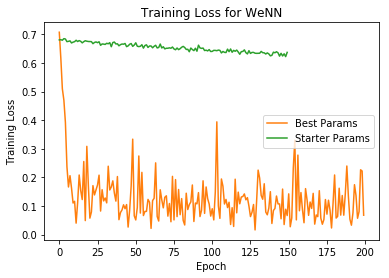

In [35]:
m1 = (200, 32, 0.001, 128, 0)
import matplotlib.pyplot as plt

plt.plot(range(len(bestLoss)), bestLoss, 'C1', label='Best Params')
plt.plot(range(len(s)), s, 'C2', label='Starter Params')


plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss for WeNN')
plt.legend()

plt.show()

In [ ]:
results = bestTrainer.test(test)
file = open('best_we_testLabels.txt', 'w')
file.write('id,toxic,severe_toxic,obscene,threat,insult,identity_hate\n')
for i in range(len(result)):
    file.write(str(test.values[i][0]) + "," +",".join(str(x) for x in result[i].tolist()))
    file.write("\n")
file.close()

Processing  0 / 100
Processing  1 / 100
